#### Load library

In [ ]:
import os
import time
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score
from torchvision import models


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/tim"

In [ ]:
# 정규화 및 transform 설정
normalize = transforms.Normalize(mean=[0.5184, 0.4233, 0.3783],
                                 std=[0.2486, 0.2229, 0.2204])

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

# 경로
train_dir = data_path + '/dataset/train'
test_dir = data_path + '/dataset/test'

# 전체 데이터셋 불러오기
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# 클래스 라벨 매핑
class_to_idx = full_train_dataset.class_to_idx
print("클래스 라벨 매핑:", class_to_idx)  # 예: {'fake': 0, 'real': 1}

# 각 클래스별 valid 인덱스 500개씩 추출
targets = np.array(full_train_dataset.targets)
valid_idx = []

for class_id in np.unique(targets):
    class_indices = np.where(targets == class_id)[0]
    selected = np.random.choice(class_indices, 500, replace=False)
    valid_idx.extend(selected)

# train 인덱스 = 전체 - valid
valid_idx = set(valid_idx)
all_idx = set(range(len(full_train_dataset)))
train_idx = list(all_idx - valid_idx)
valid_idx = list(valid_idx)

# Subset으로 나누기
train_dataset = Subset(full_train_dataset, train_idx)
valid_dataset = Subset(full_train_dataset, valid_idx)

# DataLoader 설정
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# 각 로더 길이 출력
print(f"Train Loader Length: {len(train_loader)} batches ({len(train_dataset)} samples)")
print(f"Valid Loader Length: {len(valid_loader)} batches ({len(valid_dataset)} samples)")
print(f"Test Loader Length:  {len(test_loader)} batches ({len(test_dataset)} samples)")


클래스 라벨 매핑: {'fake': 0, 'real': 1}
Train Loader Length: 63 batches (4000 samples)
Valid Loader Length: 16 batches (1000 samples)
Test Loader Length:  16 batches (1000 samples)


#### train & test

In [ ]:
# Traninig
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, dataloader, device, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)                        # (batch, 1)
        loss = criterion(outputs, labels)              # BCEWithLogitsLoss
        loss.backward()
        optimizer.step()


        total_loss += loss.item()
        preds = torch.sigmoid(outputs) > 0.5           # threshold
        correct += (preds == labels.bool()).sum().item()
        total += labels.size(0)

    return correct / total, total_loss / len(dataloader)

def test(model, dataloader, device, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels.bool()).sum().item()
            total += labels.size(0)

    return correct / total, total_loss / len(dataloader)

#### evaluate

In [ ]:
def plot_loss_accuracy(logs):
    import matplotlib.pyplot as plt

    epochs = range(1, len(logs['train_loss']) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, logs['train_loss'], label='Train Loss')
    plt.plot(epochs, logs['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, logs['train_acc'], label='Train Acc')
    plt.plot(epochs, logs['val_acc'], label='Validation Acc')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
def compute_metrics(model, dataloader, device):
    import torch
    from sklearn.metrics import confusion_matrix, classification_report

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy().astype(int)
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.numpy())

    report = classification_report(all_labels, all_preds, target_names=['fake', 'real'], output_dict=True)
    acc = report['accuracy']
    recall = report['real']['recall']
    f1 = report['real']['f1-score']
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    specificity = tn / (tn + fp)

    print(f"Accuracy: {acc:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Specificity: {specificity:.4f}")


In [ ]:
def plot_confusion_matrix(model, dataloader, device):
    import torch
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy().astype(int)
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['fake', 'real'], yticklabels=['fake', 'real'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
def plot_roc_curve(model, dataloader, device):
    import torch
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc

    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            y_scores.extend(probs.cpu().numpy())
            y_true.extend(labels.numpy())

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total}")
    print(f"Trainable Parameters: {trainable}")


In [ ]:
def measure_inference_time_per_image(model, dataloader, device, max_images=100):
    import time
    model.eval()
    total_images = 0
    total_time = 0.0

    with torch.no_grad():
        for images, _ in dataloader:
            batch_size = images.size(0)
            images = images.to(device)

            start_time = time.time()
            _ = model(images)
            elapsed = time.time() - start_time

            total_images += batch_size
            total_time += elapsed

            if total_images >= max_images:
                break

    avg_time_per_image = total_time / total_images
    print(f"Average inference time per image (on {total_images} images): {avg_time_per_image:.6f} seconds")


#### FC만 학습

In [ ]:
# model
# MobileNet 모델 정의
def get_mobilenet_fc_only():
    model = models.mobilenet_v2(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    return model


In [ ]:
from tqdm import tqdm
import os
import numpy as np

EPOCHS = 100
logs = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

criterion = nn.BCEWithLogitsLoss()
patience = 5
counter = 0
best_loss = np.inf

model = get_mobilenet_fc_only().to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.007)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(model, train_loader, device, criterion, optimizer)
    val_acc, val_loss = test(model, valid_loader, device, criterion)

    print(f"[Epoch {epoch}] train_loss = {train_loss:.4f}, train_acc = {train_acc:.4f} | "
          f"val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}", flush=True)

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    lr_scheduler.step()

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/mobilenet_fc_only_best.pth")
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered")
        # test_acc, test_loss = test(model, test_loader, device, criterion)
        # print(f"Final Test Accuracy: {test_acc:.4f}")
        break


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 0] train_loss = 0.6485, train_acc = 0.6595 | val_loss = 0.4999, val_acc = 0.7580


  1%|          | 1/100 [00:08<14:38,  8.87s/it]

[Epoch 1] train_loss = 0.5458, train_acc = 0.7248 | val_loss = 0.4842, val_acc = 0.7690


  2%|▏         | 2/100 [00:17<14:29,  8.88s/it]

[Epoch 2] train_loss = 0.5246, train_acc = 0.7440 | val_loss = 0.4658, val_acc = 0.7810


  3%|▎         | 3/100 [00:26<14:23,  8.90s/it]

[Epoch 3] train_loss = 0.5136, train_acc = 0.7422 | val_loss = 0.4733, val_acc = 0.7650


  4%|▍         | 4/100 [00:35<14:09,  8.85s/it]

[Epoch 4] train_loss = 0.4997, train_acc = 0.7680 | val_loss = 0.4627, val_acc = 0.7830


  5%|▌         | 5/100 [00:43<13:46,  8.71s/it]

[Epoch 5] train_loss = 0.5403, train_acc = 0.7368 | val_loss = 0.4907, val_acc = 0.7750


  6%|▌         | 6/100 [00:52<13:40,  8.73s/it]

[Epoch 6] train_loss = 0.5054, train_acc = 0.7508 | val_loss = 0.4581, val_acc = 0.7760


  7%|▋         | 7/100 [01:01<13:36,  8.78s/it]

[Epoch 7] train_loss = 0.5087, train_acc = 0.7545 | val_loss = 0.6188, val_acc = 0.6970


  8%|▊         | 8/100 [01:10<13:19,  8.69s/it]

[Epoch 8] train_loss = 0.5016, train_acc = 0.7575 | val_loss = 0.4795, val_acc = 0.7830


  9%|▉         | 9/100 [01:18<13:09,  8.67s/it]

[Epoch 9] train_loss = 0.5203, train_acc = 0.7578 | val_loss = 0.4447, val_acc = 0.7870


 10%|█         | 10/100 [01:27<13:04,  8.72s/it]

[Epoch 10] train_loss = 0.4917, train_acc = 0.7645 | val_loss = 0.4564, val_acc = 0.7720


 11%|█         | 11/100 [01:36<12:52,  8.68s/it]

[Epoch 11] train_loss = 0.5620, train_acc = 0.7380 | val_loss = 0.4500, val_acc = 0.7910


 12%|█▏        | 12/100 [01:44<12:41,  8.66s/it]

[Epoch 12] train_loss = 0.5228, train_acc = 0.7570 | val_loss = 0.4524, val_acc = 0.7870


 13%|█▎        | 13/100 [01:53<12:40,  8.74s/it]

[Epoch 13] train_loss = 0.5102, train_acc = 0.7565 | val_loss = 0.4523, val_acc = 0.7850


 14%|█▍        | 14/100 [02:02<12:31,  8.73s/it]

[Epoch 14] train_loss = 0.5292, train_acc = 0.7592 | val_loss = 0.5823, val_acc = 0.7140


 14%|█▍        | 14/100 [02:10<13:23,  9.35s/it]

Early stopping triggered


Final Test Accuracy: 0.7640


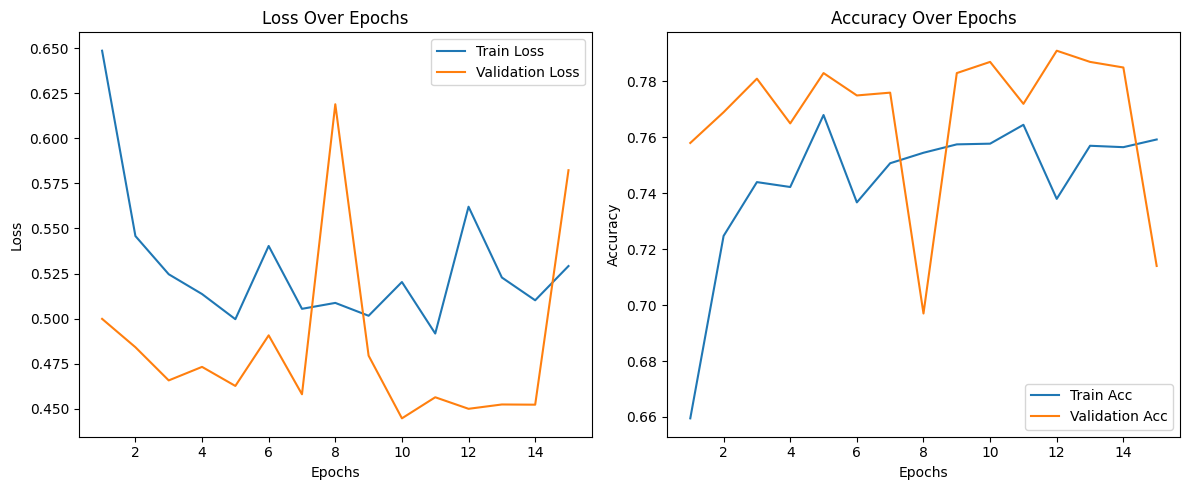

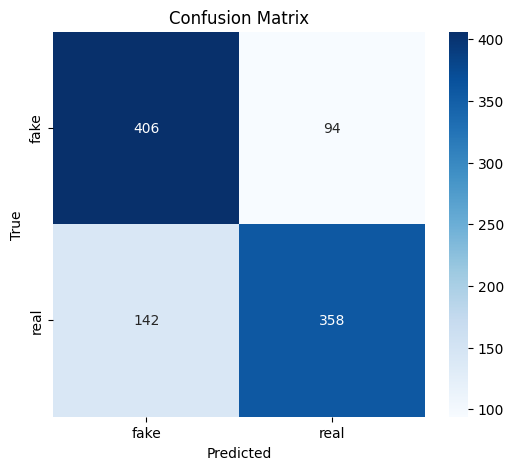

Accuracy: 0.7640
Recall (Sensitivity): 0.7160
F1-score: 0.7521
Specificity: 0.8120


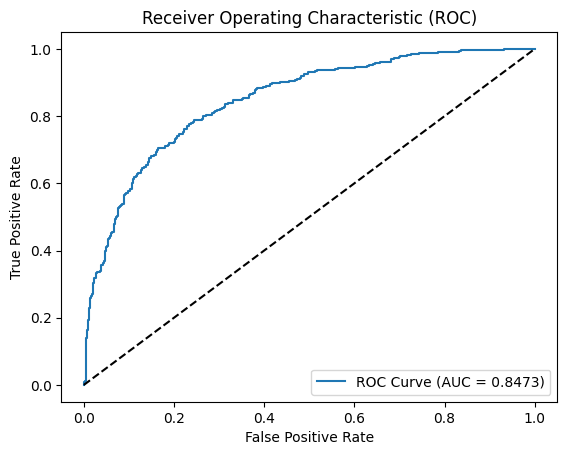

Total Parameters: 2225153
Trainable Parameters: 1281
Average inference time per image (on 128 images): 0.000165 seconds


In [ ]:
# 모델 정의
model = get_mobilenet_fc_only().to(device)

# 저장된 파라미터 로드
model.load_state_dict(torch.load("checkpoints/mobilenet_fc_only_best.pth", map_location=device))

test_acc, test_loss = test(model, test_loader, device, criterion)
print(f"Final Test Accuracy: {test_acc:.4f}")

# Accuracy, Loss 그래프
plot_loss_accuracy(logs)

# Confusion Matrix
plot_confusion_matrix(model, test_loader, device)

# 정밀도/재현율/특이도 등
compute_metrics(model, test_loader, device)

# ROC 곡선
plot_roc_curve(model, test_loader, device)

# 파라미터 개수
count_parameters(model)

# 추론 시간
measure_inference_time_per_image(model, test_loader, device)

#### FC + BN

In [ ]:
def get_mobilenet_bn_trainable():
    model = models.mobilenet_v2(pretrained=True)
    for name, param in model.named_parameters():
        if "bn" not in name:
            param.requires_grad = False
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    return model

In [ ]:
from tqdm import tqdm
import os
import numpy as np

EPOCHS = 100
logs = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

criterion = nn.BCEWithLogitsLoss()
patience = 5
counter = 0
best_loss = np.inf

model = get_mobilenet_bn_trainable().to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(model, train_loader, device, criterion, optimizer)
    val_acc, val_loss = test(model, valid_loader, device, criterion)

    print(f"[Epoch {epoch}] train_loss = {train_loss:.4f}, train_acc = {train_acc:.4f} | "
          f"val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}", flush=True)

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    lr_scheduler.step()

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/mobilenet_fc_bc_best.pth")
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered")
        test_acc, test_loss = test(model, test_loader, device, criterion)
        print(f"Final Test Accuracy: {test_acc:.4f}")
        break


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 0] train_loss = 0.6734, train_acc = 0.5823 | val_loss = 0.6445, val_acc = 0.6700


  1%|          | 1/100 [00:09<15:05,  9.15s/it]

[Epoch 1] train_loss = 0.6417, train_acc = 0.6490 | val_loss = 0.6175, val_acc = 0.7060


  2%|▏         | 2/100 [00:17<14:38,  8.97s/it]

[Epoch 2] train_loss = 0.6217, train_acc = 0.6810 | val_loss = 0.5992, val_acc = 0.7270


  3%|▎         | 3/100 [00:26<14:14,  8.81s/it]

[Epoch 3] train_loss = 0.5999, train_acc = 0.6983 | val_loss = 0.5844, val_acc = 0.7360


  4%|▍         | 4/100 [00:35<14:07,  8.83s/it]

[Epoch 4] train_loss = 0.5952, train_acc = 0.6957 | val_loss = 0.5749, val_acc = 0.7340


  5%|▌         | 5/100 [00:43<13:46,  8.70s/it]

[Epoch 5] train_loss = 0.5834, train_acc = 0.7075 | val_loss = 0.5658, val_acc = 0.7400


  6%|▌         | 6/100 [00:52<13:33,  8.66s/it]

[Epoch 6] train_loss = 0.5754, train_acc = 0.7157 | val_loss = 0.5585, val_acc = 0.7450


  7%|▋         | 7/100 [01:01<13:23,  8.64s/it]

[Epoch 7] train_loss = 0.5712, train_acc = 0.7147 | val_loss = 0.5544, val_acc = 0.7330


  8%|▊         | 8/100 [01:09<13:09,  8.58s/it]

[Epoch 8] train_loss = 0.5622, train_acc = 0.7232 | val_loss = 0.5485, val_acc = 0.7420


  9%|▉         | 9/100 [01:18<13:02,  8.60s/it]

[Epoch 9] train_loss = 0.5596, train_acc = 0.7228 | val_loss = 0.5445, val_acc = 0.7530


 10%|█         | 10/100 [01:26<12:55,  8.61s/it]

[Epoch 10] train_loss = 0.5527, train_acc = 0.7345 | val_loss = 0.5393, val_acc = 0.7430


 11%|█         | 11/100 [01:35<12:47,  8.62s/it]

[Epoch 11] train_loss = 0.5507, train_acc = 0.7275 | val_loss = 0.5354, val_acc = 0.7460


 12%|█▏        | 12/100 [01:44<12:38,  8.62s/it]

[Epoch 12] train_loss = 0.5477, train_acc = 0.7262 | val_loss = 0.5331, val_acc = 0.7460


 13%|█▎        | 13/100 [01:52<12:30,  8.62s/it]

[Epoch 13] train_loss = 0.5436, train_acc = 0.7352 | val_loss = 0.5301, val_acc = 0.7570


 14%|█▍        | 14/100 [02:01<12:21,  8.62s/it]

[Epoch 14] train_loss = 0.5429, train_acc = 0.7312 | val_loss = 0.5275, val_acc = 0.7560


 15%|█▌        | 15/100 [02:10<12:14,  8.64s/it]

[Epoch 15] train_loss = 0.5388, train_acc = 0.7318 | val_loss = 0.5245, val_acc = 0.7550


 16%|█▌        | 16/100 [02:18<12:08,  8.68s/it]

[Epoch 16] train_loss = 0.5335, train_acc = 0.7398 | val_loss = 0.5226, val_acc = 0.7570


 17%|█▋        | 17/100 [02:27<11:52,  8.59s/it]

[Epoch 17] train_loss = 0.5279, train_acc = 0.7370 | val_loss = 0.5213, val_acc = 0.7580


 18%|█▊        | 18/100 [02:35<11:45,  8.60s/it]

[Epoch 18] train_loss = 0.5322, train_acc = 0.7405 | val_loss = 0.5210, val_acc = 0.7580


 19%|█▉        | 19/100 [02:44<11:31,  8.54s/it]

[Epoch 19] train_loss = 0.5271, train_acc = 0.7445 | val_loss = 0.5178, val_acc = 0.7630


 20%|██        | 20/100 [02:52<11:24,  8.56s/it]

[Epoch 20] train_loss = 0.5253, train_acc = 0.7482 | val_loss = 0.5162, val_acc = 0.7500


 21%|██        | 21/100 [03:01<11:20,  8.61s/it]

[Epoch 21] train_loss = 0.5261, train_acc = 0.7448 | val_loss = 0.5145, val_acc = 0.7630


 22%|██▏       | 22/100 [03:10<11:11,  8.61s/it]

[Epoch 22] train_loss = 0.5245, train_acc = 0.7402 | val_loss = 0.5124, val_acc = 0.7570


 23%|██▎       | 23/100 [03:18<11:05,  8.64s/it]

[Epoch 23] train_loss = 0.5195, train_acc = 0.7418 | val_loss = 0.5110, val_acc = 0.7680


 24%|██▍       | 24/100 [03:27<10:53,  8.60s/it]

[Epoch 24] train_loss = 0.5204, train_acc = 0.7485 | val_loss = 0.5103, val_acc = 0.7570


 25%|██▌       | 25/100 [03:35<10:42,  8.56s/it]

[Epoch 25] train_loss = 0.5210, train_acc = 0.7500 | val_loss = 0.5090, val_acc = 0.7630


 26%|██▌       | 26/100 [03:44<10:39,  8.64s/it]

[Epoch 26] train_loss = 0.5159, train_acc = 0.7418 | val_loss = 0.5070, val_acc = 0.7680


 27%|██▋       | 27/100 [03:53<10:31,  8.65s/it]

[Epoch 27] train_loss = 0.5142, train_acc = 0.7472 | val_loss = 0.5062, val_acc = 0.7670


 28%|██▊       | 28/100 [04:02<10:25,  8.69s/it]

[Epoch 28] train_loss = 0.5145, train_acc = 0.7502 | val_loss = 0.5050, val_acc = 0.7610


 29%|██▉       | 29/100 [04:10<10:15,  8.67s/it]

[Epoch 29] train_loss = 0.5168, train_acc = 0.7440 | val_loss = 0.5049, val_acc = 0.7570


 30%|███       | 30/100 [04:19<10:07,  8.68s/it]

[Epoch 30] train_loss = 0.5116, train_acc = 0.7448 | val_loss = 0.5028, val_acc = 0.7660


 31%|███       | 31/100 [04:28<09:56,  8.64s/it]

[Epoch 31] train_loss = 0.5130, train_acc = 0.7610 | val_loss = 0.5031, val_acc = 0.7650


 32%|███▏      | 32/100 [04:36<09:46,  8.63s/it]

[Epoch 32] train_loss = 0.5081, train_acc = 0.7528 | val_loss = 0.5013, val_acc = 0.7630


 33%|███▎      | 33/100 [04:45<09:36,  8.60s/it]

[Epoch 33] train_loss = 0.5067, train_acc = 0.7590 | val_loss = 0.5002, val_acc = 0.7690


 34%|███▍      | 34/100 [04:53<09:28,  8.61s/it]

[Epoch 34] train_loss = 0.5110, train_acc = 0.7528 | val_loss = 0.4999, val_acc = 0.7670


 35%|███▌      | 35/100 [05:02<09:20,  8.63s/it]

[Epoch 35] train_loss = 0.5084, train_acc = 0.7535 | val_loss = 0.5001, val_acc = 0.7670


 36%|███▌      | 36/100 [05:11<09:11,  8.62s/it]

[Epoch 36] train_loss = 0.5054, train_acc = 0.7525 | val_loss = 0.4984, val_acc = 0.7680


 37%|███▋      | 37/100 [05:19<09:00,  8.59s/it]

[Epoch 37] train_loss = 0.5049, train_acc = 0.7520 | val_loss = 0.4984, val_acc = 0.7670


 38%|███▊      | 38/100 [05:27<08:49,  8.54s/it]

[Epoch 38] train_loss = 0.5017, train_acc = 0.7585 | val_loss = 0.4964, val_acc = 0.7710


 39%|███▉      | 39/100 [05:36<08:44,  8.60s/it]

[Epoch 39] train_loss = 0.5043, train_acc = 0.7558 | val_loss = 0.4983, val_acc = 0.7530


 40%|████      | 40/100 [05:45<08:37,  8.63s/it]

[Epoch 40] train_loss = 0.5046, train_acc = 0.7622 | val_loss = 0.4959, val_acc = 0.7690


 41%|████      | 41/100 [05:54<08:30,  8.65s/it]

[Epoch 41] train_loss = 0.5039, train_acc = 0.7578 | val_loss = 0.4951, val_acc = 0.7710


 42%|████▏     | 42/100 [06:02<08:25,  8.71s/it]

[Epoch 42] train_loss = 0.5000, train_acc = 0.7582 | val_loss = 0.4957, val_acc = 0.7650


 43%|████▎     | 43/100 [06:11<08:15,  8.69s/it]

[Epoch 43] train_loss = 0.5047, train_acc = 0.7555 | val_loss = 0.4957, val_acc = 0.7640


 44%|████▍     | 44/100 [06:20<08:04,  8.65s/it]

[Epoch 44] train_loss = 0.5034, train_acc = 0.7555 | val_loss = 0.4942, val_acc = 0.7720


 45%|████▌     | 45/100 [06:28<07:55,  8.64s/it]

[Epoch 45] train_loss = 0.4980, train_acc = 0.7618 | val_loss = 0.4955, val_acc = 0.7580


 46%|████▌     | 46/100 [06:37<07:47,  8.66s/it]

[Epoch 46] train_loss = 0.5005, train_acc = 0.7600 | val_loss = 0.4937, val_acc = 0.7700


 47%|████▋     | 47/100 [06:45<07:36,  8.61s/it]

[Epoch 47] train_loss = 0.5009, train_acc = 0.7558 | val_loss = 0.4929, val_acc = 0.7690


 48%|████▊     | 48/100 [06:54<07:28,  8.63s/it]

[Epoch 48] train_loss = 0.5019, train_acc = 0.7572 | val_loss = 0.4923, val_acc = 0.7720


 49%|████▉     | 49/100 [07:03<07:22,  8.67s/it]

[Epoch 49] train_loss = 0.4952, train_acc = 0.7612 | val_loss = 0.4920, val_acc = 0.7670


 50%|█████     | 50/100 [07:11<07:10,  8.62s/it]

[Epoch 50] train_loss = 0.4944, train_acc = 0.7600 | val_loss = 0.4911, val_acc = 0.7660


 51%|█████     | 51/100 [07:20<06:57,  8.52s/it]

[Epoch 51] train_loss = 0.5016, train_acc = 0.7555 | val_loss = 0.4914, val_acc = 0.7640


 52%|█████▏    | 52/100 [07:28<06:48,  8.52s/it]

[Epoch 52] train_loss = 0.4978, train_acc = 0.7578 | val_loss = 0.4922, val_acc = 0.7700


 53%|█████▎    | 53/100 [07:37<06:44,  8.60s/it]

[Epoch 53] train_loss = 0.4961, train_acc = 0.7632 | val_loss = 0.4906, val_acc = 0.7690


 54%|█████▍    | 54/100 [07:46<06:37,  8.63s/it]

[Epoch 54] train_loss = 0.5026, train_acc = 0.7615 | val_loss = 0.4911, val_acc = 0.7690


 55%|█████▌    | 55/100 [07:55<06:31,  8.70s/it]

[Epoch 55] train_loss = 0.4963, train_acc = 0.7568 | val_loss = 0.4904, val_acc = 0.7730


 56%|█████▌    | 56/100 [08:03<06:22,  8.68s/it]

[Epoch 56] train_loss = 0.5008, train_acc = 0.7565 | val_loss = 0.4907, val_acc = 0.7690


 57%|█████▋    | 57/100 [08:12<06:11,  8.65s/it]

[Epoch 57] train_loss = 0.4942, train_acc = 0.7678 | val_loss = 0.4902, val_acc = 0.7710


 58%|█████▊    | 58/100 [08:21<06:05,  8.71s/it]

[Epoch 58] train_loss = 0.4947, train_acc = 0.7540 | val_loss = 0.4902, val_acc = 0.7640


 59%|█████▉    | 59/100 [08:29<05:57,  8.71s/it]

[Epoch 59] train_loss = 0.4964, train_acc = 0.7685 | val_loss = 0.4895, val_acc = 0.7690


 60%|██████    | 60/100 [08:38<05:47,  8.68s/it]

[Epoch 60] train_loss = 0.4950, train_acc = 0.7612 | val_loss = 0.4895, val_acc = 0.7680


 61%|██████    | 61/100 [08:46<05:36,  8.62s/it]

[Epoch 61] train_loss = 0.4984, train_acc = 0.7640 | val_loss = 0.4898, val_acc = 0.7670


 62%|██████▏   | 62/100 [08:55<05:26,  8.60s/it]

[Epoch 62] train_loss = 0.4964, train_acc = 0.7575 | val_loss = 0.4894, val_acc = 0.7660


 63%|██████▎   | 63/100 [09:04<05:19,  8.63s/it]

[Epoch 63] train_loss = 0.4903, train_acc = 0.7582 | val_loss = 0.4880, val_acc = 0.7690


 64%|██████▍   | 64/100 [09:12<05:08,  8.58s/it]

[Epoch 64] train_loss = 0.4955, train_acc = 0.7580 | val_loss = 0.4879, val_acc = 0.7680


 65%|██████▌   | 65/100 [09:21<05:01,  8.61s/it]

[Epoch 65] train_loss = 0.4901, train_acc = 0.7642 | val_loss = 0.4873, val_acc = 0.7670


 66%|██████▌   | 66/100 [09:30<04:55,  8.69s/it]

[Epoch 66] train_loss = 0.4919, train_acc = 0.7632 | val_loss = 0.4876, val_acc = 0.7690


 67%|██████▋   | 67/100 [09:38<04:47,  8.70s/it]

[Epoch 67] train_loss = 0.4981, train_acc = 0.7560 | val_loss = 0.4878, val_acc = 0.7720


 68%|██████▊   | 68/100 [09:47<04:36,  8.65s/it]

[Epoch 68] train_loss = 0.4960, train_acc = 0.7568 | val_loss = 0.4874, val_acc = 0.7690


 69%|██████▉   | 69/100 [09:56<04:29,  8.68s/it]

[Epoch 69] train_loss = 0.4920, train_acc = 0.7618 | val_loss = 0.4875, val_acc = 0.7660


 70%|███████   | 70/100 [10:04<04:20,  8.67s/it]

[Epoch 70] train_loss = 0.4922, train_acc = 0.7632 | val_loss = 0.4874, val_acc = 0.7670
Early stopping triggered


 70%|███████   | 70/100 [10:15<04:23,  8.79s/it]

Final Test Accuracy: 0.7450


Final Test Accuracy: 0.7480


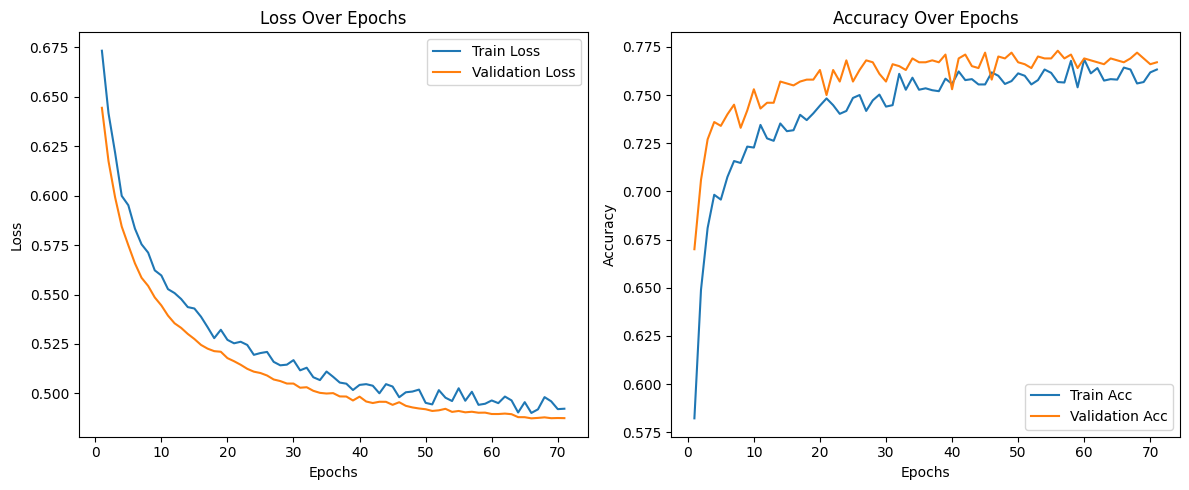

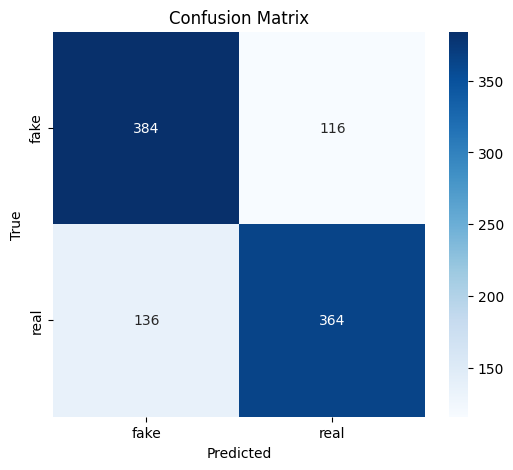

Accuracy: 0.7480
Recall (Sensitivity): 0.7280
F1-score: 0.7429
Specificity: 0.7680


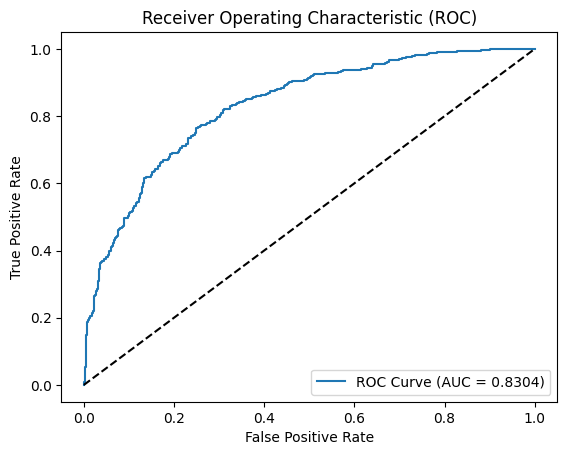

Total Parameters: 2225153
Trainable Parameters: 1281
Average inference time per image (on 128 images): 0.000186 seconds


In [ ]:
# 모델 정의
model = get_mobilenet_bn_trainable().to(device)

# 저장된 파라미터 로드
model.load_state_dict(torch.load("checkpoints/mobilenet_fc_bc_best.pth", map_location=device))
test_acc, test_loss = test(model, test_loader, device, criterion)
print(f"Final Test Accuracy: {test_acc:.4f}")
# Accuracy, Loss 그래프
plot_loss_accuracy(logs)

# Confusion Matrix
plot_confusion_matrix(model, test_loader, device)

# 정밀도/재현율/특이도 등
compute_metrics(model, test_loader, device)

# ROC 곡선
plot_roc_curve(model, test_loader, device)

# 파라미터 개수
count_parameters(model)

# 추론 시간
measure_inference_time_per_image(model, test_loader, device)

#### 학습 X - 출력층 노드 개수만 변환

In [ ]:
def get_mobilenet_zeroshot():
    model = models.mobilenet_v2(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False  # 전체 freeze

    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)  # 출력 바꾸기
    for param in model.classifier[1].parameters():
        param.requires_grad = False  # classifier까지 freeze

    return model


In [ ]:
from tqdm import tqdm
import os
import numpy as np

EPOCHS = 100
logs = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

best_loss = np.inf

model = get_mobilenet_zeroshot().to(device)
torch.save(model.state_dict(), 'checkpoints/mobilenet_fc_node_best.pth')


test_acc, test_loss = test(model, test_loader, device, criterion)
print(f"Final Test Accuracy: {test_acc:.4f}")

Final Test Accuracy: 0.5080


Final Test Accuracy: 0.5080


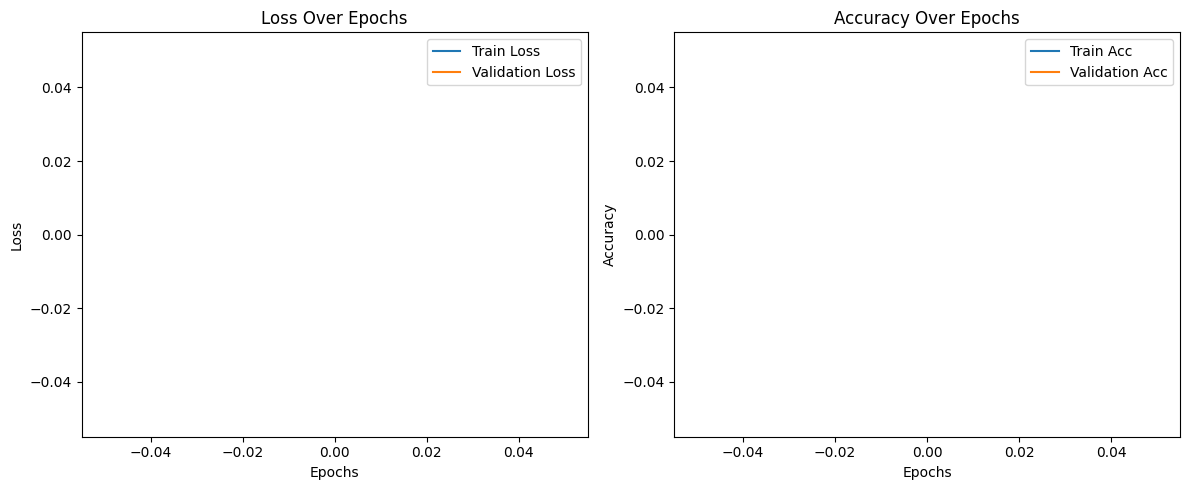

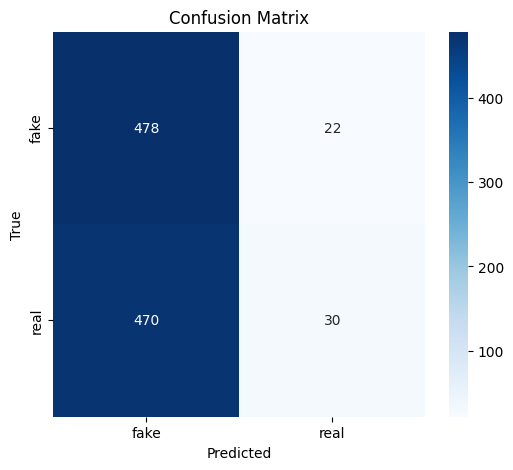

Accuracy: 0.5080
Recall (Sensitivity): 0.0600
F1-score: 0.1087
Specificity: 0.9560


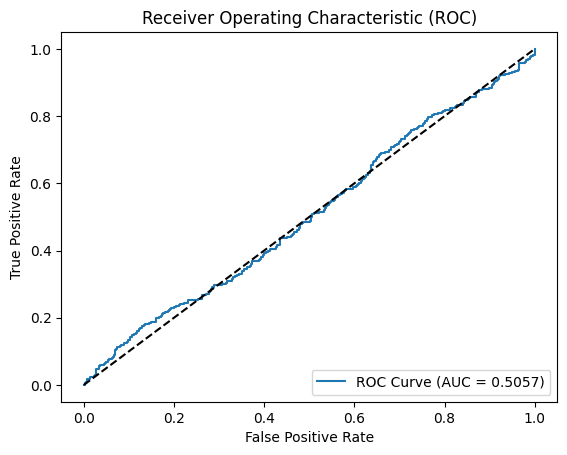

Total Parameters: 2225153
Trainable Parameters: 0
Average inference time per image (on 128 images): 0.000178 seconds


In [ ]:
# 모델 정의
model = get_mobilenet_zeroshot().to(device)

# 저장된 파라미터 로드
model.load_state_dict(torch.load("checkpoints/mobilenet_fc_node_best.pth", map_location=device))  # 파일명 변경
test_acc, test_loss = test(model, test_loader, device, criterion)
print(f"Final Test Accuracy: {test_acc:.4f}")

# Accuracy, Loss 그래프
plot_loss_accuracy(logs)

# Confusion Matrix
plot_confusion_matrix(model, test_loader, device)

# 정밀도/재현율/특이도 등
compute_metrics(model, test_loader, device)

# ROC 곡선
plot_roc_curve(model, test_loader, device)

# 파라미터 개수
count_parameters(model)

# 추론 시간
measure_inference_time_per_image(model, test_loader, device)

#### 상위 블록만 학습

In [ ]:
def get_mobilenet_partial_tune(n_blocks=3):
    model = models.mobilenet_v2(pretrained=True)
    # 전체 freeze
    for param in model.parameters():
        param.requires_grad = False

    # 마지막 n_blocks만 학습 가능하도록 설정
    blocks = list(model.features.children())  # MobileNet의 features 레이어들을 리스트로 변환
    for block in blocks[-n_blocks:]:
        for param in block.parameters():
            param.requires_grad = True

    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    for param in model.classifier[1].parameters():
        param.requires_grad = True
    return model

In [ ]:
from tqdm import tqdm
import os
import numpy as np

EPOCHS = 100
logs = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

criterion = nn.BCEWithLogitsLoss()
patience = 5
counter = 0
best_loss = np.inf

model = get_mobilenet_partial_tune().to(device)  # ResNet50 → MobileNet으로 변경

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00005)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(model, train_loader, device, criterion, optimizer)
    val_acc, val_loss = test(model, valid_loader, device, criterion)

    print(f"[Epoch {epoch}] train_loss = {train_loss:.4f}, train_acc = {train_acc:.4f} | "
          f"val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}", flush=True)

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    lr_scheduler.step()

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/mobilenet_partial_4_best.pth")  # 파일명 변경
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered")
        test_acc, test_loss = test(model, test_loader, device, criterion)
        print(f"Final Test Accuracy: {test_acc:.4f}")
        break

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 0] train_loss = 0.5751, train_acc = 0.6970 | val_loss = 0.4889, val_acc = 0.7690


  1%|          | 1/100 [00:08<14:39,  8.89s/it]

[Epoch 1] train_loss = 0.4477, train_acc = 0.7987 | val_loss = 0.4180, val_acc = 0.8130


  2%|▏         | 2/100 [00:17<14:35,  8.93s/it]

[Epoch 2] train_loss = 0.3693, train_acc = 0.8380 | val_loss = 0.3780, val_acc = 0.8290


  3%|▎         | 3/100 [00:26<14:22,  8.89s/it]

[Epoch 3] train_loss = 0.3056, train_acc = 0.8730 | val_loss = 0.3480, val_acc = 0.8460


  4%|▍         | 4/100 [00:35<14:04,  8.79s/it]

[Epoch 4] train_loss = 0.2496, train_acc = 0.9012 | val_loss = 0.3344, val_acc = 0.8530


  5%|▌         | 5/100 [00:44<13:57,  8.82s/it]

[Epoch 5] train_loss = 0.2010, train_acc = 0.9310 | val_loss = 0.3234, val_acc = 0.8580


  6%|▌         | 6/100 [00:52<13:41,  8.74s/it]

[Epoch 6] train_loss = 0.1490, train_acc = 0.9543 | val_loss = 0.3358, val_acc = 0.8540


  7%|▋         | 7/100 [01:01<13:26,  8.67s/it]

[Epoch 7] train_loss = 0.1118, train_acc = 0.9695 | val_loss = 0.3263, val_acc = 0.8540


  8%|▊         | 8/100 [01:09<13:16,  8.66s/it]

[Epoch 8] train_loss = 0.0878, train_acc = 0.9765 | val_loss = 0.3347, val_acc = 0.8700


  9%|▉         | 9/100 [01:18<13:09,  8.68s/it]

[Epoch 9] train_loss = 0.0607, train_acc = 0.9890 | val_loss = 0.3329, val_acc = 0.8730


 10%|█         | 10/100 [01:27<13:01,  8.68s/it]

[Epoch 10] train_loss = 0.0453, train_acc = 0.9950 | val_loss = 0.3421, val_acc = 0.8730
Early stopping triggered


 10%|█         | 10/100 [01:37<14:40,  9.78s/it]

Final Test Accuracy: 0.8630


Final Test Accuracy: 0.8570


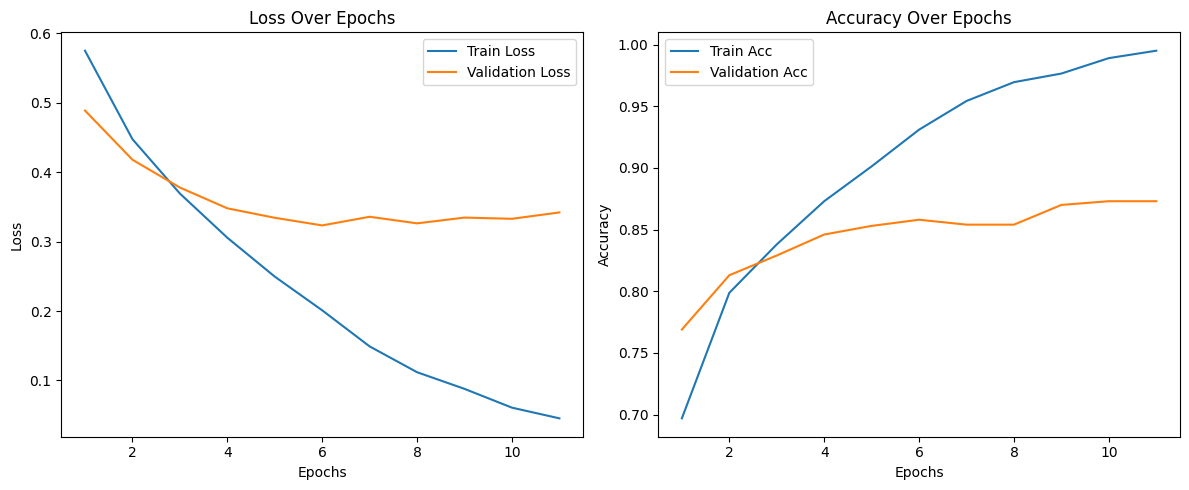

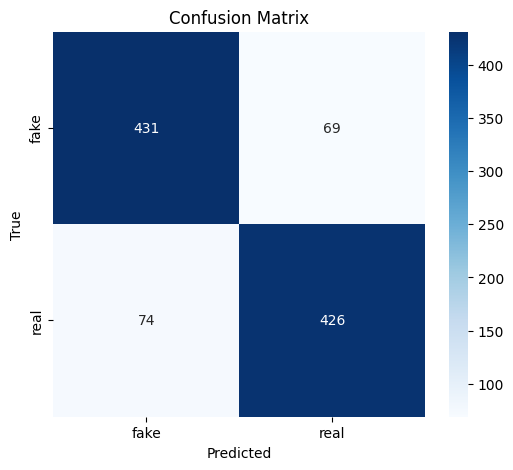

Accuracy: 0.8570
Recall (Sensitivity): 0.8520
F1-score: 0.8563
Specificity: 0.8620


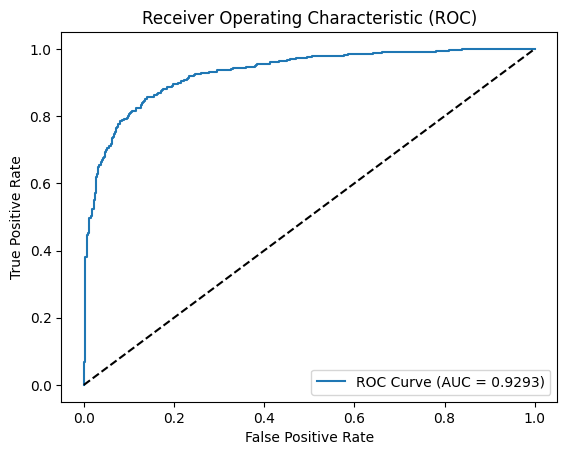

Total Parameters: 2225153
Trainable Parameters: 1207361
Average inference time per image (on 128 images): 0.000234 seconds


In [ ]:
# 모델 정의
model = get_mobilenet_partial_tune().to(device)  # ResNet50 → MobileNet으로 변경

# 저장된 파라미터 로드
model.load_state_dict(torch.load("checkpoints/mobilenet_partial_4_best.pth", map_location=device))  # 파일명 변경

test_acc, test_loss = test(model, test_loader, device, criterion)
print(f"Final Test Accuracy: {test_acc:.4f}")

# Accuracy, Loss 그래프
plot_loss_accuracy(logs)

# Confusion Matrix
plot_confusion_matrix(model, test_loader, device)

# 정밀도/재현율/특이도 등
compute_metrics(model, test_loader, device)

# ROC 곡선
plot_roc_curve(model, test_loader, device)

# 파라미터 개수
count_parameters(model)

# 추론 시간
measure_inference_time_per_image(model, test_loader, device)

#### 전체 fine-tuning

In [88]:
def get_mobilenet_full_finetune():
    model = models.mobilenet_v2(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)  # binary classification

    # 전체 레이어 학습 가능 (기본값이지만 명시적 표현)
    for param in model.parameters():
        param.requires_grad = True

    return model

In [89]:
from tqdm import tqdm
import os
import numpy as np

EPOCHS = 100
logs = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

criterion = nn.BCEWithLogitsLoss()
patience = 5
counter = 0
best_loss = np.inf

model = get_mobilenet_full_finetune().to(device)  # ResNet50 → MobileNet으로 변경

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(model, train_loader, device, criterion, optimizer)
    val_acc, val_loss = test(model, valid_loader, device, criterion)

    print(f"[Epoch {epoch}] train_loss = {train_loss:.4f}, train_acc = {train_acc:.4f} | "
          f"val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}", flush=True)

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    lr_scheduler.step()

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/mobilenet_full_best.pth")  # 파일명 변경
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered")
        test_acc, test_loss = test(model, test_loader, device, criterion)
        print(f"Final Test Accuracy: {test_acc:.4f}")
        break

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 0] train_loss = 0.4151, train_acc = 0.8105 | val_loss = 0.4465, val_acc = 0.8330


  1%|          | 1/100 [00:08<14:42,  8.91s/it]

[Epoch 1] train_loss = 0.1428, train_acc = 0.9443 | val_loss = 0.5091, val_acc = 0.8260


  2%|▏         | 2/100 [00:17<14:43,  9.01s/it]

[Epoch 2] train_loss = 0.1026, train_acc = 0.9600 | val_loss = 0.3053, val_acc = 0.8850


  3%|▎         | 3/100 [00:27<14:56,  9.25s/it]

[Epoch 3] train_loss = 0.0465, train_acc = 0.9838 | val_loss = 0.3530, val_acc = 0.8940


  4%|▍         | 4/100 [00:36<14:27,  9.03s/it]

[Epoch 4] train_loss = 0.0224, train_acc = 0.9925 | val_loss = 0.3869, val_acc = 0.8960


  5%|▌         | 5/100 [00:45<14:19,  9.05s/it]

[Epoch 5] train_loss = 0.0345, train_acc = 0.9882 | val_loss = 0.3405, val_acc = 0.9050


  6%|▌         | 6/100 [00:54<14:06,  9.01s/it]

[Epoch 6] train_loss = 0.0278, train_acc = 0.9925 | val_loss = 0.5669, val_acc = 0.8620


  7%|▋         | 7/100 [01:03<13:52,  8.96s/it]

[Epoch 7] train_loss = 0.0583, train_acc = 0.9800 | val_loss = 0.3125, val_acc = 0.8990
Early stopping triggered


  7%|▋         | 7/100 [01:13<16:21, 10.56s/it]

Final Test Accuracy: 0.8950


Final Test Accuracy: 0.8950


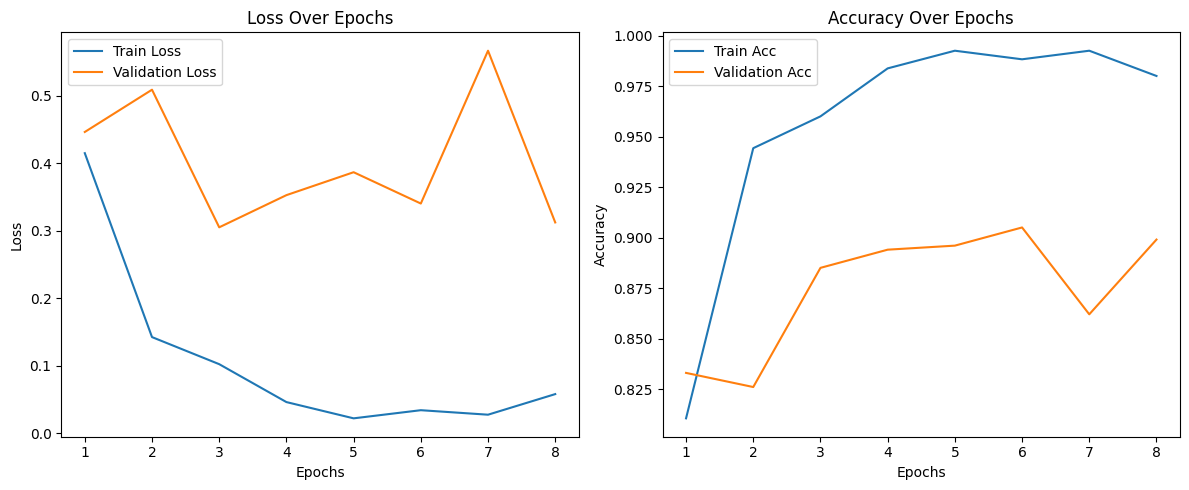

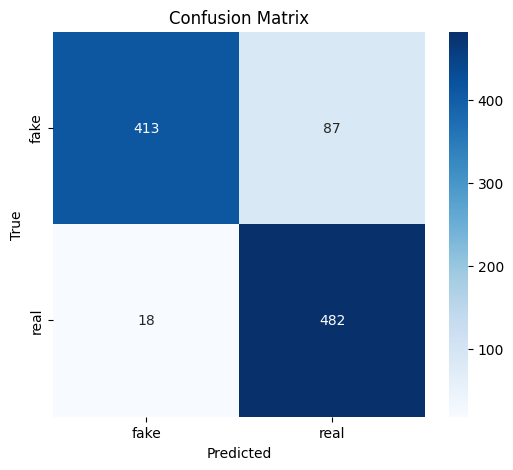

Accuracy: 0.8950
Recall (Sensitivity): 0.9640
F1-score: 0.9018
Specificity: 0.8260


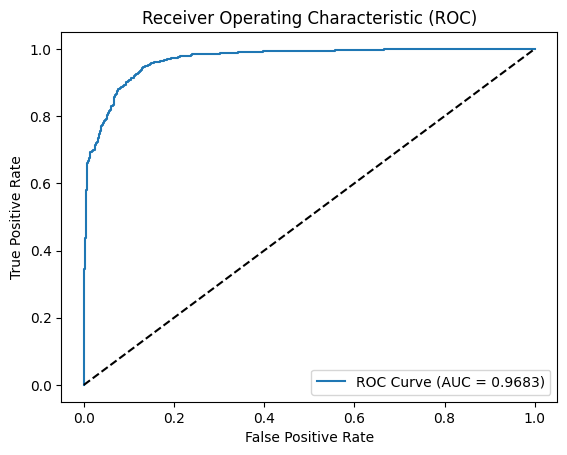

Total Parameters: 2225153
Trainable Parameters: 2225153
Average inference time per image (on 128 images): 0.000226 seconds


In [90]:
# 모델 정의
model = get_mobilenet_full_finetune().to(device)  # ResNet50 → MobileNet으로 변경

# 저장된 파라미터 로드
model.load_state_dict(torch.load("checkpoints/mobilenet_full_best.pth", map_location=device))  # 파일명 변경

test_acc, test_loss = test(model, test_loader, device, criterion)
print(f"Final Test Accuracy: {test_acc:.4f}")

# Accuracy, Loss 그래프
plot_loss_accuracy(logs)

# Confusion Matrix
plot_confusion_matrix(model, test_loader, device)

# 정밀도/재현율/특이도 등
compute_metrics(model, test_loader, device)

# ROC 곡선
plot_roc_curve(model, test_loader, device)

# 파라미터 개수
count_parameters(model)

# 추론 시간
measure_inference_time_per_image(model, test_loader, device)

In [87]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 135.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.6 

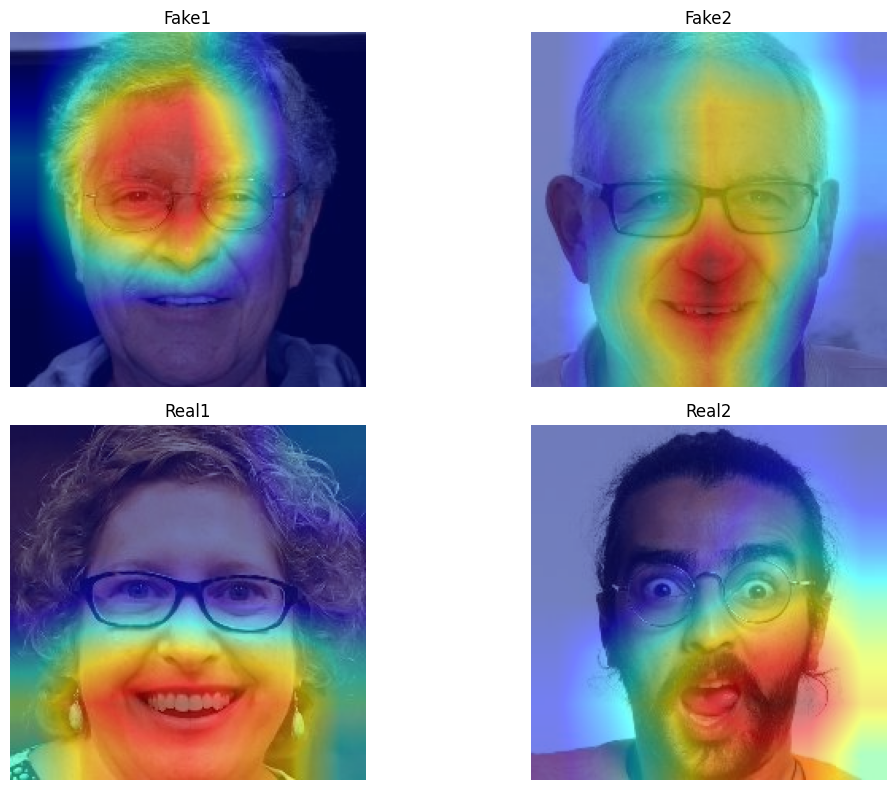

In [93]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import torch

# 마지막 Convolution layer 설정 (MobileNet 기준)
target_layer = model.features[-1]

# Grad-CAM 객체 생성
cam = GradCAM(model=model, target_layers=[target_layer])

# Normalize 해제 (ImageNet 기준일 경우)
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

def show_gradcam_examples():
    fake_imgs = []
    real_imgs = []

    # test_loader에서 이미지 추출 (fake: 0, real: 1)
    for images, labels in test_loader:
        for img, label in zip(images, labels):
            if label.item() == 0 and len(fake_imgs) < 2:
                fake_imgs.append(img)
            elif label.item() == 1 and len(real_imgs) < 2:
                real_imgs.append(img)
            if len(fake_imgs) == 2 and len(real_imgs) == 2:
                break
        if len(fake_imgs) == 2 and len(real_imgs) == 2:
            break

    selected_imgs = fake_imgs + real_imgs
    selected_labels = [0, 0, 1, 1]
    titles = ["Fake1", "Fake2", "Real1", "Real2"]

    plt.figure(figsize=(12, 8))

    for i, (img, label, title) in enumerate(zip(selected_imgs, selected_labels, titles)):
        input_tensor = img.unsqueeze(0).to(device)
        targets = [BinaryClassifierOutputTarget(label)]

        # Grad-CAM 계산
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

        # 이미지 복원 (unnormalize)
        img_np = inv_normalize(img).permute(1, 2, 0).cpu().numpy()
        img_np = np.clip(img_np, 0, 1)

        # CAM 오버레이 생성
        cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)


        # 시각화
        plt.subplot(2, 2, i + 1)
        plt.imshow(cam_image)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 실행
show_gradcam_examples()
